**Lesson 11 – Decision Trees on IRIS**

Decision Trees, like SVMs, can perform both classification and regression tasks, even multioutput tasks. 
* They are able to fit complex datasets.
* They are the fundamental components of random forests.

In [1]:
%run setup.ipynb

## Training and Visualizing a Decision Tree

Try to make predictions on the iris dataset.

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

import pydot

(graph,) = pydot.graph_from_dot_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))
graph.write_png(os.path.join(IMAGES_PATH, "iris_tree.png"))

Suppose you want to find an iris flower and you want to classify it.



![IRIS Decision Tree](../images/iris_tree.png)

You start at the root node (depth 0 at the top). This node asks whether the flower's petal length is smaller than 2.45 cm. If it is, then you move down to the root's left child node (depth 1, left), which is a leaf node, so it does not ask any questions. The leaf node looks at the predicted class for that node and the decision tree predicts that your flower is an iris setosa.

Suppose you find another flower and the petal length is greater than 2.45 cm, you move down to the root's right child node (depth 1, right), which is not a leaf node and the node asks another question: is the petal width smaller than 1.75 cm? If so, then your flower is most liley an iris versicolor (depth 2, left), otherwise it is likely an iris virginica (depth 2, right).

The decision trees do not require feature scaling or centering at all.

A node's samples attribute counts how many training instances it applies to. For example
* 100 training instances have a petal length greater than 2.45 cm, with 54 smaller than 1.75 cm

A node's value attribute tell you how many training instances of each class this node applies to:
* the bottom-right node applies to 0 iris setosa, 1 iris versicolor and 45 to iris virginica

A node's gini attribute measures its impurity: a node is pure (gini=0) if all training instances it applies to belong to the same class. 
* the depth-1 left node applies to iris setosa training instances, it is pure and its gini score is 0
* the depth-2 left node has a gini score equal to $1-(0/54)^2-(49/54)^2-(5/54)^2$ almost 0.168.

## Making Predictions

Saving figure decision_tree_decision_boundaries_plot


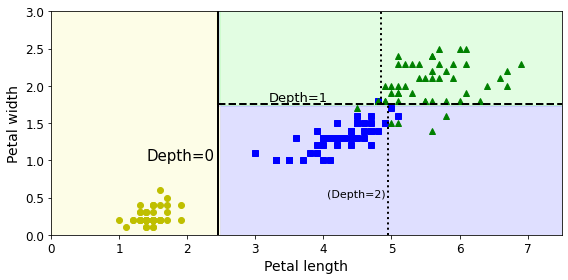

In [4]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

The plot shows the Decision Tree's Decision Boundaries. The thick vertical line represents the decision boundary of the root node (depth=0) with petal lenght equal to 2.45 cm.
* the left hand is pure with only iris setosa so it is not further split. 
* the right hand is impure, so the depth-1 right node splits it at petal width 1.75 cm where there is the dashed line

Since `max_depth` was set to 2, the decision tree stops right there.

Scikit-learn uses the CART algorithm, which produces only binary trees: nonleaf nodes always have to children: questions only have yes/no answers. Other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children. 

The CART algorithm works by first splitting the training set into two subsets using a single feature `k` and a threshold $t_k$ (e.g., petal legth <= 2.45 cm). 
* It searches for the pair (k, $t_k$) that produces the purest subsets weighted by their size. Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-sets, and so on, recursively. 
* It stops recursing once it reaches the maximum depth or if it cannot find a split that will reduce impurity.

CART searches for an optimum split at the top level, then repeats the process at each sunsequent level. Finding the optimal tree is an NP-Complete problem. It requires O(exp(m)) time.

# Estimating Class Probabilities

A decision tree can also estimate the probability that an instance belongs to a particular class k. 
* first it traverses the tree to find the leaf node for this instance
* then it returns the ratio of training instances of class k in this node

If we have to find a lower whose petals are 5 cm long and 1.5 cm wide, the corresponding leaf node is the depth-2 left.

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

The decision tree should output the following probabilities: 0% for iris setosa, 90.7% for irits versicolor and 9.3% for iris virginica.

If you ask to predict the class.

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

The decision tree should output iris versicolor (class 1), because it has the highest probability.

## Instability

We've seen that small changes in the dataset (such as a rotation) may produce a very different Decision Tree.
Now let's show that training the same model on the same data may produce a very different model every time, since the `CART` training algorithm used by `scikit-Learn` is stochastic. To show this, we will set `random_state` to a different value than earlier:

In [7]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=40)

Saving figure decision_tree_instability_plot


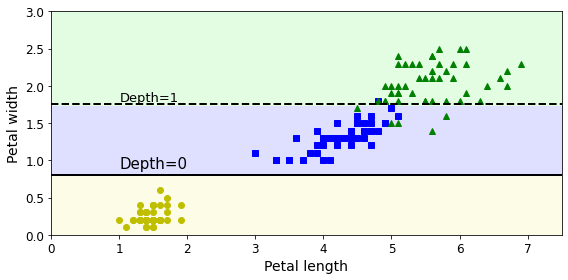

In [8]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

It is important to set the same random_state hyperparameter. However, random forest can limit this instability by averaging predictions over many trees.